# Ejemplo lo más explicado que pueda con lenguaje súper natural 😅

Primero que todo necesitamos datos para encontrar el sistema que los describe.

Para esto vamos a generar los datos de un modelo que ya conocemos para así comparar si el modelo obtenido por el algorítmo coincide con el original, tomaremos el modelo poblacional SIR:

    S’ = - a*I*S
    I’ = a*I*S - b*I
    R’ = b*I

Escribamos una función en python que describa este modelo:

In [1]:
# modelo del SIR
def sir_dx(X, t, a, b):
    S = X[0]
    I = X[1]
    R = X[2]

    return [-a * I * S, a * I * S - b * I, b * I]

Se recibe el tiempo dentro de la función aunque no se utilice porque estamos haciendo este ejemplo para que sea lo más abarcador y genérico posible. Es un ejemplo :D

En este modelo los valores de a y b son parámetros que indican la cantidad de personas que pasan de estar saludables a infectados y de infectados a recuperados, respectivamente. Estos valores también deseamos que sean encontrados por el algorítmo.

Para generar los datos debemos tener un punto inicial, o sea. Un cantidad de saludables, infectados y recuperados iniciales, además debemos conocer cuánto tiempo deseamos en los datos de entrenamiento, además de la cantidad de muestras que se le pasarán al algorítmo.

In [2]:
from sympy.plotting.textplot import linspace
from scipy import integrate
from matplotlib import pyplot as plt

def integrate_sir(time, samples, X0, a, b):
    t = linspace(0, time, samples)

    X, _ = integrate.odeint(sir_dx, X0, t, (a, b), full_output=True)

    S, I, R = X.T

    return (t, S, I, R)

# valores de los parámtros del modelo SIR
a = 0.3
b = 0.4

# punto inicial
X0 = [0.7, 0.3, 0]

# tiempo en el que se generarán los casos de entrenamiento
time = 20

# cantidad de muestras
n = 10000

# datos de entrenamiento
t, S, I, R = integrate_sir(time, n, X0, a, b)

Se muestran los datos para saber que forma visual tienen los datos del modelo

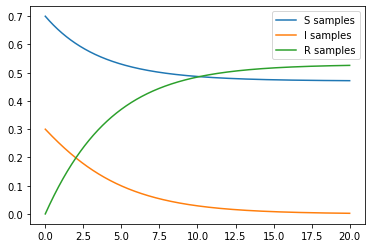

In [3]:
plt.plot(t, S, label="S samples")
plt.plot(t, I, label="I samples")
plt.plot(t, R, label="R samples")
plt.legend()
plt.show()

Perfecto, ya tenemos datos iniciales para nuestro algorítmo 🥳🥳🥳. Hasta ahora no hemos hecho nada de regresión simbólica ni algoritmos genéticos 😓, solo hemos generado datos que no teníamos, pero conocemos el modelo exacto del cuál los datos salieron.

Ahora es cuando vamos a meterle 😀😁.

Tenemos 10000 muestras ahora mismo, pero queremos comprobar cuan bueno es el algorítmo sin tener taaaaantos datos, por eso vamos a reducir la cantidad de muestras, y solo tomaremos 200, para que pase trabajo.

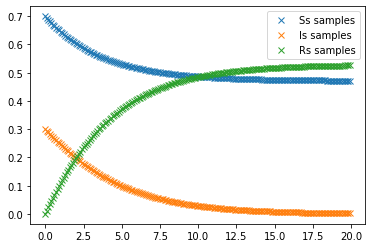

In [5]:
from src.utils import take_n_samples_regular

samples = 200

ts = take_n_samples_regular(samples, t)
Ss = take_n_samples_regular(samples, S)
Is = take_n_samples_regular(samples, I)
Rs = take_n_samples_regular(samples, R)

plt.plot(ts, Ss, 'x', label="Ss samples")
plt.plot(ts, Is, 'x', label="Is samples")
plt.plot(ts, Rs, 'x', label="Rs samples")
plt.legend()
plt.show()

La entrada de los datos al algorítmo debe ser de una forma "especial", en vez de ser un conjuno de listas como tenemos ahora mismo, debe ser una sola y única lista de entrada, y una sola y única lista de salida. Definiendo entrada como las muestras y la salida, las muestras evaluadas en el modelo 😅.

La datos de la lista de entrada son diccionarios, en donde las llaves son los nombres de las variables y los valores son los valores de esas variables en cada uno de los datos.

Los datos de la lista de salida es solamente el modelo evaluado en las muestras.

In [6]:
X_samples = [
        {"t": ts[i], "S": Ss[i], "I": Is[i], "R": Rs[i]} for i in range(len(ts))
    ]

ode = [sir_dx([Ss[i], Is[i], Rs[i]], ts[i], a, b) for i in range(len(ts))]

Con los datos listos podemos llamar a la función que se encarga de la regresión simbólica, y esta realizará todos los cálculos chinos por nosotros, completamente invisible y lista para usarse

In [7]:
from src.symbolic_regression import symbolic_regression

results = symbolic_regression(
        X_samples,
        ode,
        seed_g=0,
        MAX_GENERATIONS=100,
        POP_SIZE=100,
        FEATURES_NAMES=[["S", "I"], ["S", "I"], ["I"]],
        MUTATION_SIZE=50,
        XOVER_SIZE=50,
        MAX_DEPTH=5,
        REG_STRENGTH=20,
        verbose=False,
    )

best_system = results["system"]

WOW, eso fue rápido, solamente 2.3 segundos.... (en mi máquina al menos :) ) Pero este fue un salto grande, qué son todos esos parámetros?, qué contiene el results? No preocuparse, pronto nos meteremos dentro y veremos que contiene y qué fue lo que pasó dentro. Pero primero veamos que retornó (resaltar que lo que retorna y recibe cada función está documentado pero igual aqui esto es un ejemplo desde 0 así que lo explico).

results es un diccionario que posee todas los datos de los parámetros utilizados durante la ejecución de la función además de:

- time: tiempo que tomó la ejecución
- score: puntuación obtenida por el mejor sistema alcanzado
- generations: cantidad de generaciones que tuvieron lugar
- system: nodo que representa el sistema que mejor acercamiento tuvo al conjunto de datos de entrada
- system_representation: representación del system

Luego veremos mejor que son estas cosas, pero por ahora solo nos importa system, que lo almacenamos dentro de la variable best_system.

Qué es este system, pues este es el sistema de ecuaciones que encontró el algorítmo. Con los parámetros encontrados y tal. si evaluamos este sistema en los datos podremos ver que tan parecido es con respecto a los datos originales.


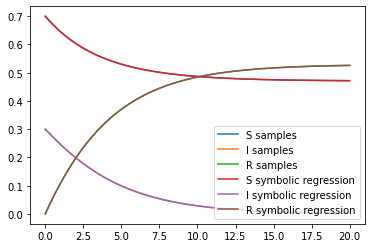

In [8]:
from src.utils import evaluate

integrate_gp = lambda X, t: evaluate(
        best_system, {"t": t, "S": X[0], "I": X[1], "R": X[2]}
    )

SIR_gp, infodict = integrate.odeint(integrate_gp, X0, t, full_output=True)

S_gp, I_gp, R_gp = SIR_gp.T

plt.plot(t, S, label="S samples")
plt.plot(t, I, label="I samples")
plt.plot(t, R, label="R samples")
plt.plot(t, S_gp, label="S symbolic regression")
plt.plot(t, I_gp, label="I symbolic regression")
plt.plot(t, R_gp, label="R symbolic regression")
plt.legend()
plt.show()

🥳🥳🥳🥳🥳 es casi casi el mismo, de hecho podemos ver sus ecuaciones para comprobar si en realidad es el mismo.

In [9]:
print(results["system_representation"])

1 : -0.3 * (I * S) 
2 : -0.4 * I + 0.3 * (I * S) 
3 : 0.13333 * I + 0.13333 * I + 0.13333 * I 



jejeje, si nos fijamos bien la última ecuación en realidad es la misma del modelo original a pesar de estar dividida en esa suma tan poco bonita.

Entonces, ya viendo que funciona (al menos en este ejemplo tan sencillito), vale la pena ver que lo que está pasando dentro de la función symbolic_regression.

Vemos que recibimos un número grande de parámetros que explicaremos mientras se vayan usando para entender mejor.

Luego se incia el temporizador que será utilizado para comprobar cuánto tiempo tomó la ejecución de todo el algorítmo. Se inicializa la semilla que se utilizará en los "randoms" de la ejecución.

En features_names se almacenan los nombres de las variables que pueden aparecer en cada ecuación del sistema, o sea una una lista de listas en caso de que se pase en los parámetros, en caso de que este no se envíe pues se utilizan todos los parámetros en todas las ecuaciones. Esto es fundamentalmente para ser utilizado si conocemos información del sistema que se desea encontrar.

En operations se guardan las operaciones que pueden aparecer dentro de las ecuaciones del sistema.

A continuación se crea la población inicial del algorítmo genérico. Para esto se utiliza la función random_system que crea sistemas de ecuaciones aleatorios utilizando las variables en cada ecuación definidas anteriormente, junto con las operaciones, además se hace uso del parámetro MAX_DEPTH para controlar la profundidad que pueden tener estos árboles. La población inicial generada contiene POP_SIZE individuos.

Entonces inciamos las generaciones. Definida la máxima cantidad que pueden ocurrir de estas por el parámtro MAX_GENERATIONS.

Dentro de cada generación se toma una cantidad de individuos igual a MUTATION_SIZE para ser mutados, resaltar que no es que se muten estos encima del mismo sistema, si no que se crea otro con el resultado de la mutación. Estos individuos mutados son guardados en mutations_populations.

Lo que hizo esta función fue seleccionar aleatoriamente individuos de la población y aplicar la función mutate_system sobre ellos. Esta función selecciona un nodo aleatorio dentro del árbol representante del sistema y editar alguna de sus carácterísticas. Estas mutaciones pueden ir desde eliminar un subárbol a sencillamente cambiar la operación en un nodo.

Luego se realiza un proceso similar pero esta vez en vez de mutar a individuos, se cruzan entre ellos. Se cruzan una cantidad de 2 * XOVER_SIZE, para obtener un total de XOVER_SIZE individuos resultantes de cruzamientos. La función xover lo que hace es tomar dos sistemas de ecuaciones y devolver uno nuevo con características en común de ambos padres.

Entonces podemos generar una nueva población que contiene a la población incial, los individuos mutados y los individuos resultantes de los cruzamientos. Esta nueva población es guardada en total_population.

De estos sistemas no conocemos mucho, y necesitamos filtrarlos para quedarnos con una cantidad igual a la población inicial, además de ver que tan bueno fue el mejor de la población generada.

Para esto se recorren todos los individuos optimizando sus parámetros para que se ajusten al conjunto de datos. Esto se hace llamando a la función lineal_optimization_system que esta genera un sistema de ecuaciones lineales por cada una de las ecuaciones del sistema optimizando los parámetros y asignándolos en el sistema. Una vez los parámetros han sido ajustados se evalua la calidad del sistema con la función compute_fitness, que esta compara los resultados obtenidos en las evaluaciones del sistema y los resultados objetivos. Mientras este resultado sea lo más cercano a 0, quiere decir que la diferencia entre los resultados es cada menor, por lo tanto es mejor.

Si en algún momento el resultado obtenido es menor que un EPSILON definido en los parámetros se detiene la ejecución. Si esto no ocurre pues pasan a la siguiente generación los individuos que mejor puntuación obtuvieron, una cantidad de estos igual a POP_SIZE.

Antes de retornar finalmente el sistema obtenido, se redondean los parámetros y se filtran aquellos que son 0 para "embellecer" el sistema



